In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# from scipy.stats import norm
from scipy.stats import bernoulli
# import imageio
import random
from os import path as path
# from itertools import islice
import time

A function to obtain the evidence threshold for making a decision, given beliefs about thetas and a temporal discounting factor. 

In [2]:
T = 100 # number of simulated time steps

def get_threshold_asym(thetas,gamma):
    # thetas are the probabilities of obtaining a 1 in target absence and presence.
    # gamma is the discounting factor
    
    # V is value
    V=np.full([T*2+1, T*2+1],np.nan);

    # A is action
    A=np.full([T*2+1, T*2+1],np.nan);

    # LLR is LLR
    LLR=np.full([T*2+1, T*2+1],np.nan);
    
    for t in range(T*2, -1, -1):
        states= np.array(range(t+1)); # number of 1's
        LLR_at_t= states*(np.log(thetas[1])- np.log(thetas[0])) + \
        (t-states)*(np.log(1-thetas[1])- np.log(1-thetas[0]));
        
        LLR[t,states]= LLR_at_t;
        
        #to avoid overflow errors
        clipped_LLR_at_t = np.clip(LLR_at_t,-500,500)

        P_present= 1/(1+np.exp(-clipped_LLR_at_t));
        
        # value if I make a decision now
        V_choose_now= np.maximum(P_present,1-P_present)
        
        if t==T*2:
            V[t, states]= V_choose_now;
            # action is 1 for choosing 'present', -1 for choosing 'absent', and 0 otherwise
            A[t,states]= np.where(LLR_at_t>0,1,-1);
            
        else:
            # calculate value if waiting
            # the probability of obtaining a 1, marginalized over target presence and absence
            prob1= P_present*thetas[1]+ (1-P_present)*thetas[0];
            V_wait= gamma*(prob1*V[t+1,states+1]+ (1-prob1)*V[t+1,states]);
            
            V[t,states] = np.maximum(V_choose_now,V_wait)
            A[t,states] = np.where(V_choose_now>V_wait,1,0) * np.where(LLR_at_t>0,1,-1)

    half_A = A[:-T]
    half_LLR = LLR[:-T]
    
    LLR_no = half_LLR[half_A==-1]
    LLR_yes = half_LLR[half_A==1]

    return([np.max(LLR_no),np.min(LLR_yes)])


Simulate_forward_asym simulates behaviour (decisions, RT and confidence) given true thetas, beliefs about thetas, and gamma. 

In [61]:
def simulate_forward_asym(true_thetas, believed_thetas, gamma, T):
    
    #1. FIND POLICY
    
    # V is value. We simulate T*2 time here so that we can use the first T to get the threshold.
    V=np.full([T*2+1, T*2+1],np.nan);

    # A is action
    A=np.full([T*2+1, T*2+1],np.nan);

    # LLR is LLR
    LLR=np.full([T*2+1, T*2+1],np.nan);
    
    # Backward induction!
    for t in range(T*2, -1, -1):
        states= np.array(range(t+1)); # the state is the number of 1's observed so far
        LLR_at_t= states*(np.log(believed_thetas[1])- np.log(believed_thetas[0])) + \
        (t-states)*(np.log(1-believed_thetas[1])- np.log(1-believed_thetas[0]));
        
        LLR[t,states]= LLR_at_t;
        
        #to avoid overflow errors later. 
        clipped_LLR_at_t = np.clip(LLR_at_t,-500,500)

        P_present= np.exp(clipped_LLR_at_t)/(1+np.exp(clipped_LLR_at_t));
        
        # the expected value if I make a decision now is the probability of being correct
        V_choose_now= np.maximum(P_present,1-P_present)
        
        # We start by assuming that the agent makes a decision at the last time point, and move backward from there.
        if t==T*2:
            V[t, states]= V_choose_now;
            # action is 1 for choosing 'present', -1 for choosing 'absent', and 0 otherwise
            A[t,states]= np.where(LLR_at_t>0,1,-1);
            
        else:
            # Calculate value if waiting
            # the probability of obtaining a 1, marginalized over target presence and absence
            prob1= P_present*believed_thetas[1]+ (1-P_present)*believed_thetas[0];
            # the expected value if I wait is gamma times the expected value in the next time point.
            V_wait= gamma*(prob1*V[t+1,states+1]+ (1-prob1)*V[t+1,states]);
            
            # the expected value is the maximum between the expected value if I wait or if I make a decision.
            V[t,states] = np.maximum(V_choose_now,V_wait)
            
            # I code 'target-present' decisions as 1, 'target-absent' decisions as -1, and waiting as 0
            A[t,states] = np.where(V_choose_now>V_wait,1,0) * np.where(LLR_at_t>0,1,-1)
    
    # 2. RUN SIMULATION FORWARD
    df = pd.DataFrame(columns=['present','p','decision','RT','confidence'])

    # run target absence trials
    prob=np.full([T+1, T+1],0.0);
    prob[0,0]=1
    for t in np.arange(0,T):
        for state in np.arange(0,t+1):
            if prob[t,state]==0:
                continue
            else:
                if A[t,state]!=0:
                    df.loc[len(df)] = [0, 
                    prob[t,state],
                    0.5+0.5*A[t,state], # converting the -1 in "target absent" to 0
                    t,
                    max(np.exp(LLR[t,state])/(1+np.exp(LLR[t,state])), 1/(1+np.exp(LLR[t,state])))]
                else:
                    prob[t+1,state] += prob[t,state]*(1-true_thetas[0])
                    prob[t+1,state+1] += prob[t,state]*true_thetas[0]
   
    # run target presence trials
    prob=np.full([T+1, T+1],0.0);
    prob[0,0]=1
    for t in np.arange(0,T):
        for state in np.arange(0,t+1):
            if prob[t,state]==0:
                continue
            else:
                if A[t,state]!=0:
                    df.loc[len(df)] = [1, 
                    prob[t,state],
                    0.5+0.5*A[t,state], # converting the -1 in "target absent" to 0
                    t,
                    max(np.exp(LLR[t,state])/(1+np.exp(LLR[t,state])), 1/(1+np.exp(LLR[t,state])))]
                else:
                    prob[t+1,state] += prob[t,state]*(1-true_thetas[1])
                    prob[t+1,state+1] += prob[t,state]*true_thetas[1]
    
    if df['p'].sum()<1.95:
       raise ValueError("increase T, a non-negligible number of trials is beyond the scope of the simulation")
        
    return(df)

Here we measure the behaviour of the model for different parameter combinations:

In [77]:
start = time.time()

RT_diff_df = pd.DataFrame(columns=['theta0','theta1','RTdiff'])
conf_diff_df = pd.DataFrame(columns=['theta0','theta1','confDiff'])
acc_df = pd.DataFrame(columns=['theta0','theta1','acc'])
bias_df = pd.DataFrame(columns=['theta0','theta1','bias'])
# this dataframe lists parameter combinations for which the ordering of RTs across response
# types is correct, that is hit < FA < CR < miss

correct_RT_order_df = pd.DataFrame(columns=['theta0','theta1','correct_order'])

# theta_values = np.array([0.05,0.1,0.15,0.2])
theta_values = np.arange(0.01,0.51,0.02)

#python is sometimes giving me .99999999999999 for some reason
theta_values = [round(theta*100)/100 for theta in theta_values]

# Function to find the median RT based on cumulative probability
def find_median_RT(group):
    return group[group['cumulative_p'] >= 0.5].iloc[0]['RT'] if not group[group['cumulative_p'] >= 0.5].empty else np.nan

for theta0 in theta_values:
    print(theta0)
    for theta1 in theta_values:
        if theta0<theta1:
            df = simulate_forward_asym([theta0,theta1],[theta0,theta1],0.99,100)
           
            median_RT_diff = (df[df['present'] == df['decision']]
              .assign(p_scaled=lambda x: x.groupby('present')['p'].transform(lambda p: p / p.sum()))
              .sort_values(by=['present', 'RT'])
              .assign(cumulative_p=lambda x: x.groupby('present')['p_scaled'].cumsum())
              .groupby('present')
              .apply(find_median_RT)
              .pipe(lambda x: x.get(1, 0) - x.get(0, 0)))
           
            RT_diff_df.loc[len(RT_diff_df)] = [theta0,
                               theta1,
                                median_RT_diff]
           
            mean_conf_diff = (df[df['present'] == df['decision']]
                 .assign(p_scaled=lambda x: x.groupby('present')['p'].transform(lambda p: p / p.sum()))
                 .assign(weighted_confidence=lambda x: x['confidence'] * x['p_scaled'])
                 .groupby('present')['weighted_confidence']
                 .sum()
                 .pipe(lambda x: x.get(1) - x.get(0)))
           
            conf_diff_df.loc[len(conf_diff_df)] = [theta0,
                               theta1,
                                mean_conf_diff]
           
            acc = (df
            .assign(correct=lambda x: x['present'] == x['decision'])
            .assign(p_scaled=lambda x: x['p'].transform(lambda p: p / p.sum()))
            .assign(weighted_correct=lambda x: x['correct'] * x['p_scaled'])
            ['weighted_correct']
            .sum())
           
            acc_df.loc[len(conf_diff_df)] = [theta0,
                               theta1,
                                acc]
           
            bias = (df
            .assign(p_scaled=lambda x: x['p'].transform(lambda p: p / p.sum()))
            .assign(bias=lambda x: x['decision'] * x['p_scaled'])
            ['bias']
            .sum())
           
            bias_df.loc[len(conf_diff_df)] = [theta0,
                               theta1,
                                bias]
            
            median_RT_order = (df
#             (df[df['present'] == df['decision']]
              .assign(p_scaled=lambda x: x.groupby(['present', 'decision'])['p'].transform(lambda p: p / p.sum()))
              .sort_values(by=['present', 'decision','RT'])
              .assign(cumulative_p=lambda x: x.groupby(['present','decision'])['p_scaled'].cumsum())
              .groupby(['present','decision'])
              .apply(find_median_RT)
#               .assign(weighted_RT=lambda x: x['RT'] * x['p_scaled'])
#               .groupby(['present','decision'])['weighted_RT']
#               .sum()
              .pipe(lambda x: (x.loc[(1, 1)] < x.loc[(0, 1)] < x.loc[(0, 0)] < x.loc[(1, 0)]).astype(int)))
           
            correct_RT_order_df.loc[len(correct_RT_order_df)] = [theta0,
                               theta1,
                                median_RT_order]
            
end = time.time()
print(end-start)

0.01
0.03
0.05
0.07
0.09
0.11
0.13
0.15
0.17
0.19
0.21
0.23
0.25
0.27
0.29
0.31
0.33
0.35
0.37
0.39
0.41
0.43
0.45
0.47
0.49
38.782073974609375


Estimating the expected RT and confidence differences between decisions about presence and absence as a function of theta.

C:\Users\tanzor\AppData\Local\Temp/ipykernel_24060/3361321512.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_df = RT_diff_df.pivot("theta0", "theta1", "RTdiff")


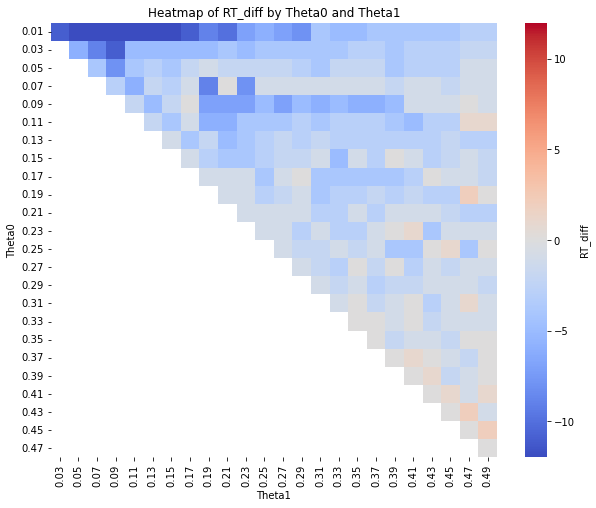

C:\Users\tanzor\AppData\Local\Temp/ipykernel_24060/3361321512.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_df = conf_diff_df.pivot("theta0", "theta1", "confDiff")


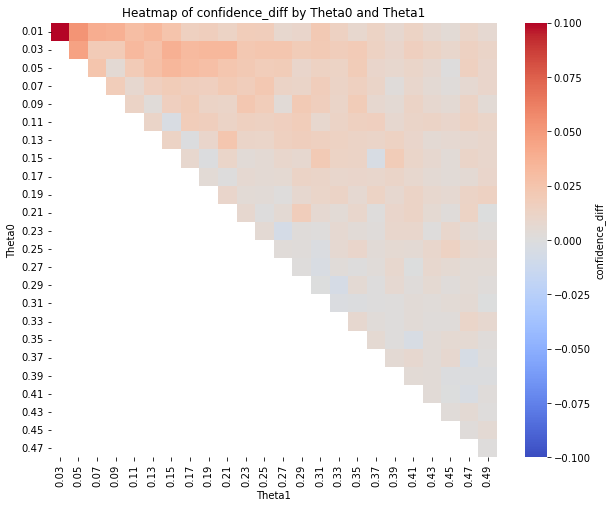

C:\Users\tanzor\AppData\Local\Temp/ipykernel_24060/3361321512.py:17: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_df = acc_df.pivot("theta0", "theta1", "acc")


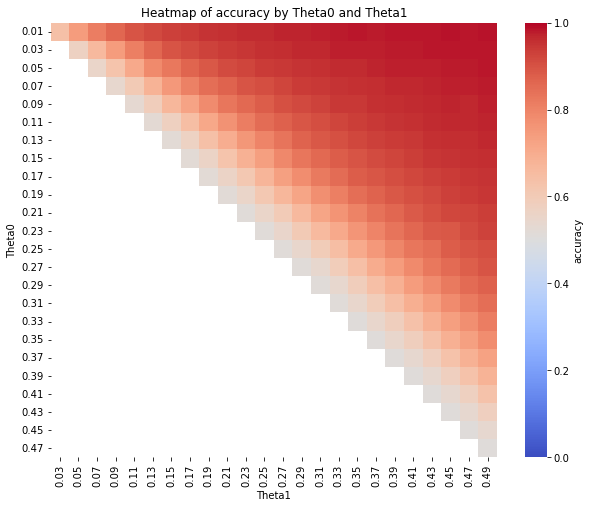

C:\Users\tanzor\AppData\Local\Temp/ipykernel_24060/3361321512.py:25: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_df = bias_df.pivot("theta0", "theta1", "bias")


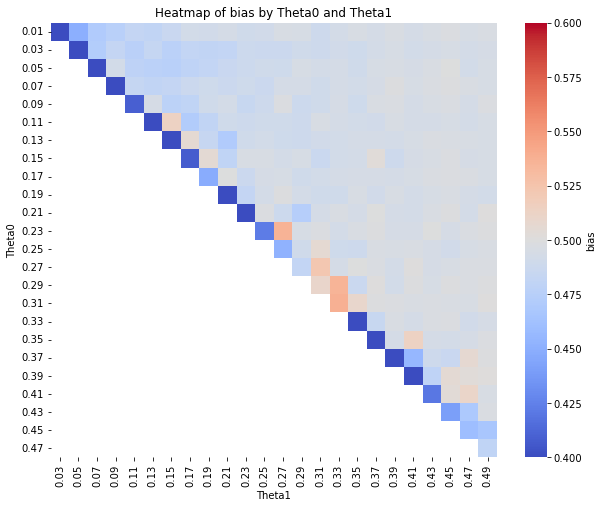

C:\Users\tanzor\AppData\Local\Temp/ipykernel_24060/3361321512.py:34: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_df = correct_RT_order_df.pivot("theta0", "theta1", "correct_order")


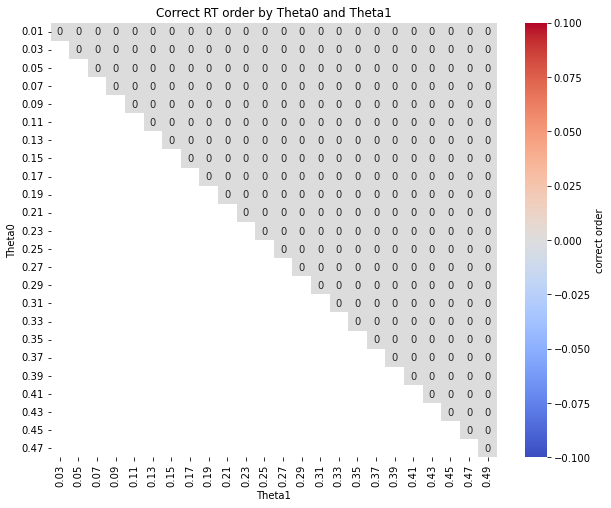

In [78]:
pivot_df = RT_diff_df.pivot("theta0", "theta1", "RTdiff")
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_df,  cmap="coolwarm", cbar_kws={'label': 'RT_diff'}, center=0, vmin=-12, vmax=12)
plt.title('Heatmap of RT_diff by Theta0 and Theta1')
plt.xlabel('Theta1')
plt.ylabel('Theta0')
plt.show()

pivot_df = conf_diff_df.pivot("theta0", "theta1", "confDiff")
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_df, cmap="coolwarm", cbar_kws={'label': 'confidence_diff'}, center=0, vmin=-0.1, vmax=0.1)
plt.title('Heatmap of confidence_diff by Theta0 and Theta1')
plt.xlabel('Theta1')
plt.ylabel('Theta0')
plt.show()

pivot_df = acc_df.pivot("theta0", "theta1", "acc")
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_df, cmap="coolwarm", cbar_kws={'label': 'accuracy'}, vmin=0, vmax=1)
plt.title('Heatmap of accuracy by Theta0 and Theta1')
plt.xlabel('Theta1')
plt.ylabel('Theta0')
plt.show()

pivot_df = bias_df.pivot("theta0", "theta1", "bias")
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_df, cmap="coolwarm", cbar_kws={'label': 'bias'}, center=0.5, vmin=0.4, vmax=0.6)
plt.title('Heatmap of bias by Theta0 and Theta1')
plt.xlabel('Theta1')
plt.ylabel('Theta0')
plt.show()


pivot_df = correct_RT_order_df.pivot("theta0", "theta1", "correct_order")
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_df, annot=True, cmap="coolwarm", cbar_kws={'label': 'correct order'})
plt.title('Correct RT order by Theta0 and Theta1')
plt.xlabel('Theta1')
plt.ylabel('Theta0')
plt.show()

Next, we simulate the effects of beliefs about alpha on RT, confidence, and guessing rates, for the same true alphas. We simulate the two conditions as [0.05, 0.15] and 0.7*[0.05,0.15] and the alphas as pairs of values averaging around 0.85, from [0.85,0.85] to [1.15,0.55].

In [80]:
big_df = pd.DataFrame()

true_alpha_values = [1,0.7]
alpha_prime_pairs = [[round((1-x)*100)/100,round((0.7+x)*100)/100] for x in np.arange(-0.2,0.16,0.01)]

theta0 = 0.05
theta1 = 0.2

for believed_alpha_values in alpha_prime_pairs:

    df_easy = simulate_forward_asym(true_alpha_values[0]*np.array([theta0,theta1]),
                                    believed_alpha_values[0]*np.array([theta0,theta1]),0.99,100)
    
    df_hard = simulate_forward_asym(true_alpha_values[1]*np.array([theta0,theta1]),
                                    believed_alpha_values[1]*np.array([theta0,theta1]),0.99,100)
    
    df_easy['condition'] = 'easy'
    df_hard['condition'] = 'hard'
    df_merged = pd.concat([df_easy,df_hard])
    df_merged['alpha_prime_easy'] = believed_alpha_values[0]
    df_merged['alpha_prime_hard'] = believed_alpha_values[1]
    df_merged['alpha_easy'] = true_alpha_values[0]
    df_merged['alpha_hard'] = true_alpha_values[1]
    
    big_df = pd.concat([big_df,df_merged])


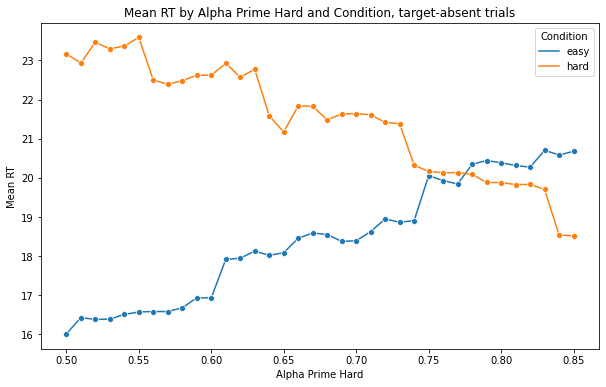

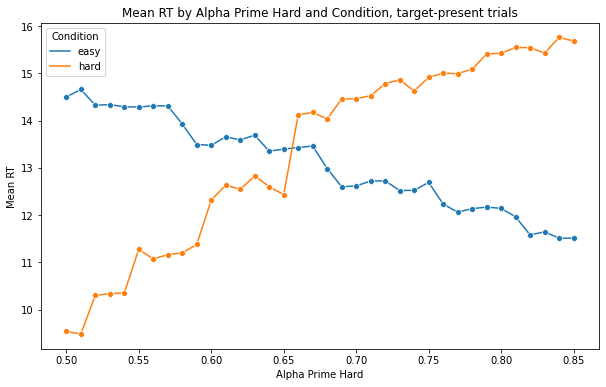

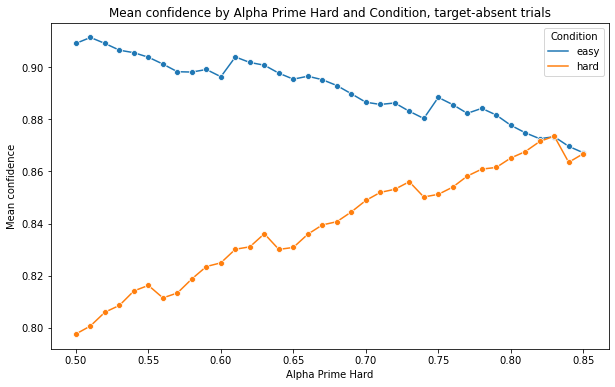

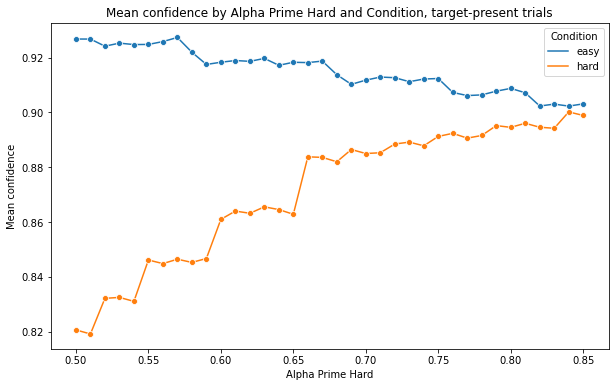

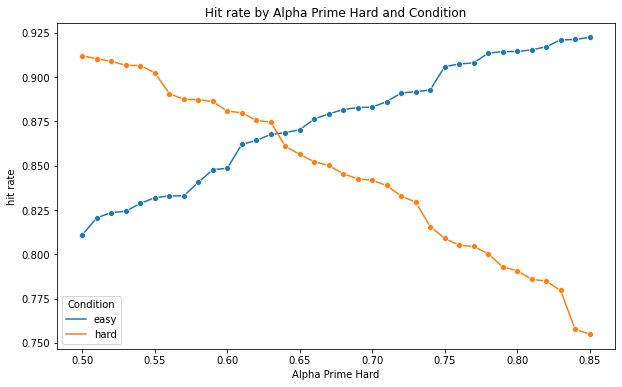

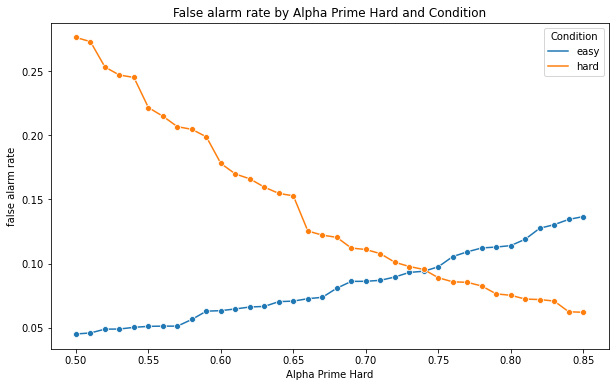

In [81]:
RT_absent = (big_df[(big_df['decision'] == 0) & (big_df['present'] == 0)]
             .assign(p_scaled=lambda x: x.groupby(['condition','present','alpha_prime_hard'])['p'].transform(lambda p: p / p.sum()))
             .assign(weighted_RT=lambda x: x['RT'] * x['p_scaled'])
             .groupby(['condition', 'alpha_prime_hard'])['weighted_RT']
            .sum()
            .reset_index())

# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=RT_absent, x='alpha_prime_hard', y='weighted_RT', hue='condition', marker='o')

plt.title('Mean RT by Alpha Prime Hard and Condition, target-absent trials')
plt.xlabel('Alpha Prime Hard')
plt.ylabel('Mean RT')
plt.legend(title='Condition')
plt.show()

RT_present = (big_df[(big_df['decision'] == 1) & (big_df['present'] == 1)]
             .assign(p_scaled=lambda x: x.groupby(['condition','present','alpha_prime_hard'])['p'].transform(lambda p: p / p.sum()))
             .assign(weighted_RT=lambda x: x['RT'] * x['p_scaled'])
             .groupby(['condition', 'alpha_prime_hard'])['weighted_RT']
            .sum()
            .reset_index())

# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=RT_present, x='alpha_prime_hard', y='weighted_RT', hue='condition', marker='o')

plt.title('Mean RT by Alpha Prime Hard and Condition, target-present trials')
plt.xlabel('Alpha Prime Hard')
plt.ylabel('Mean RT')
plt.legend(title='Condition')
plt.show()

confidence_absent = (big_df[(big_df['decision'] == 0) & (big_df['present'] == 0)]
             .assign(p_scaled=lambda x: x.groupby(['condition','present','alpha_prime_hard'])['p'].transform(lambda p: p / p.sum()))
             .assign(weighted_confidence=lambda x: x['confidence'] * x['p_scaled'])
             .groupby(['condition', 'alpha_prime_hard'])['weighted_confidence']
            .sum()
            .reset_index())

# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=confidence_absent, x='alpha_prime_hard', y='weighted_confidence', hue='condition', marker='o')

plt.title('Mean confidence by Alpha Prime Hard and Condition, target-absent trials')
plt.xlabel('Alpha Prime Hard')
plt.ylabel('Mean confidence')
plt.legend(title='Condition')
plt.show()

confidence_present = (big_df[(big_df['decision'] == 1) & (big_df['present'] == 1)]
             .assign(p_scaled=lambda x: x.groupby(['condition','present','alpha_prime_hard'])['p'].transform(lambda p: p / p.sum()))
             .assign(weighted_confidence=lambda x: x['confidence'] * x['p_scaled'])
             .groupby(['condition', 'alpha_prime_hard'])['weighted_confidence']
            .sum()
            .reset_index())

# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=confidence_present, x='alpha_prime_hard', y='weighted_confidence', hue='condition', marker='o')

plt.title('Mean confidence by Alpha Prime Hard and Condition, target-present trials')
plt.xlabel('Alpha Prime Hard')
plt.ylabel('Mean confidence')
plt.legend(title='Condition')
plt.show()

hits = (big_df[(big_df['present'] == 1)]
             .assign(p_scaled=lambda x: x.groupby(['condition','present','alpha_prime_hard'])['p'].transform(lambda p: p / p.sum()))
             .assign(weighted_hits=lambda x: x['decision'] * x['p_scaled'])
             .groupby(['condition', 'alpha_prime_hard'])['weighted_hits']
            .sum()
            .reset_index())

# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=hits, x='alpha_prime_hard', y='weighted_hits', hue='condition', marker='o')

plt.title('Hit rate by Alpha Prime Hard and Condition')
plt.xlabel('Alpha Prime Hard')
plt.ylabel('hit rate')
plt.legend(title='Condition')
plt.show()

false_alarms = (big_df[(big_df['present'] == 0)]
             .assign(p_scaled=lambda x: x.groupby(['condition','present','alpha_prime_hard'])['p'].transform(lambda p: p / p.sum()))
             .assign(weighted_fas=lambda x: x['decision'] * x['p_scaled'])
             .groupby(['condition', 'alpha_prime_hard'])['weighted_fas']
            .sum()
            .reset_index())

# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=false_alarms, x='alpha_prime_hard', y='weighted_fas', hue='condition', marker='o')

plt.title('False alarm rate by Alpha Prime Hard and Condition')
plt.xlabel('Alpha Prime Hard')
plt.ylabel('false alarm rate')
plt.legend(title='Condition')
plt.show()